<a href="https://colab.research.google.com/github/StSahtouris/StSahtouris/blob/main/cybersecurity_colab_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Φόρτωση βιβλιοθηκών
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc


In [8]:
# Φόρτωση δεδομένων από GitHub
url = 'https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/DarkNet.csv'
df = pd.read_csv(url)

# Εμφάνιση ονομάτων των στηλών
print(df.columns)

# Εμφάνιση πρώτων γραμμών
df.head()

Index(['Src_IP', 'Src_Port', 'Dst_IP', 'Dst_Port', 'Protocol', 'Flow_Duration',
       'Total_Fwd_Packet', 'Total_Bwd_packets', 'Total_Length_of_Fwd_Packet',
       'Total_Length_of_Bwd_Packet', 'Fwd_Packet_Length_Max',
       'Fwd_Packet_Length_Min', 'Fwd_Packet_Length_Mean',
       'Fwd_Packet_Length_Std', 'Bwd_Packet_Length_Max',
       'Bwd_Packet_Length_Min', 'Bwd_Packet_Length_Mean',
       'Bwd_Packet_Length_Std', 'Flow_Bytes/s', 'Flow_Packets/s',
       'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min',
       'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max',
       'Fwd_IAT_Min', 'Bwd_IAT_Total', 'Bwd_IAT_Mean', 'Bwd_IAT_Std',
       'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags',
       'Fwd_URG_Flags', 'Bwd_URG_Flags', 'Fwd_Header_Length',
       'Bwd_Header_Length', 'Fwd_Packets/s', 'Bwd_Packets/s',
       'Packet_Length_Min', 'Packet_Length_Max', 'Packet_Length_Mean',
       'Packet_Length_Std', 'Packet_Length_Variance', 'FIN_Flag

<ipython-input-8-07760c04a079>:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Flow_Duration,Total_Fwd_Packet,Total_Bwd_packets,Total_Length_of_Fwd_Packet,Total_Length_of_Bwd_Packet,...,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label-1,Label-2
0,10.152.152.11,57158,216.58.220.99,443,6,229,1,1,0,0,...,0,0,0,0,0,0.000,0,0,Non-Tor,AUDIO-STREAMING
1,10.152.152.11,57159,216.58.220.99,443,6,407,1,1,0,0,...,0,0,0,0,0,0.000,0,0,Non-Tor,AUDIO-STREAMING
2,10.152.152.11,57160,216.58.220.99,443,6,431,1,1,0,0,...,0,0,0,0,0,0.000,0,0,Non-Tor,AUDIO-STREAMING
3,10.152.152.11,49134,74.125.136.120,443,6,359,1,1,0,0,...,0,0,0,0,0,0.000,0,0,Non-Tor,AUDIO-STREAMING
4,10.152.152.11,34697,173.194.65.127,19305,6,10778451,591,400,64530,6659,...,0,0,0,0,1437760000000000,3117718.131,1437760000000000,1437760000000000,Non-Tor,AUDIO-STREAMING


In [9]:
# Έλεγχος για ελλιπείς τιμές
df.isnull().sum()

# Προεπεξεργασία δεδομένων (αφαίρεση NaN, κανονικοποίηση)
df.dropna(inplace=True)
scaler = StandardScaler()

# Επιλογή μόνο αριθμητικών χαρακτηριστικών για κλιμάκωση
numerical_features = df.drop(columns=['Label-1', 'Src_IP']).select_dtypes(include=np.number).columns

# Αντικατάσταση άπειρων τιμών με NaN
df[numerical_features] = df[numerical_features].replace([np.inf, -np.inf], np.nan)

# Συμπλήρωση ή αφαίρεση τιμών NaN εάν είναι απαραίτητο
# Αυτός ο βρόχος διατρέχει τα αριθμητικά χαρακτηριστικά και αντικαθιστά τα NaN με τον μέσο όρο
for feature in numerical_features:
    df[feature].fillna(df[feature].mean(), inplace=True)

# Αντί να απορρίψουμε όλες τις γραμμές με τιμές NaN, θα αφαιρέσουμε μόνο τα NaN στη στοχευμένη μας στήλη.
df.dropna(subset=['Label-1'], inplace=True)

# Εφαρμογή κλιμάκωσης μόνο στα αριθμητικά χαρακτηριστικά
df_scaled = scaler.fit_transform(df[numerical_features])

# Δημιουργία του X με κανονικοποιημένα αριθμητικά χαρακτηριστικά, αφαιρώντας τη στήλη 'Src_IP'.
X = pd.DataFrame(df_scaled, columns=numerical_features, index=df.index)

# Αντιστοίχιση των τιμών της στήλης 'Label-1' σε αριθμητικές τιμές, διαχειριζόμενοι τα NaN
# Αντί να συμπληρώσουμε τα NaN με -1, τα αφαιρούμε ή τα αντικαθιστούμε με 0/1 ανάλογα με το πρόβλημα.
# Εδώ υποθέτουμε ότι θέλουμε να τα αφαιρέσουμε, καθώς είχαν ήδη διαχειριστεί προηγουμένως.

y = df['Label-1'].map({'Tor': 1, 'Non-Tor': 0}).dropna()

# Φιλτράρισμα του X ώστε να διατηρήσουμε μόνο τις γραμμές που αντιστοιχούν στις μη NaN τιμές του y
X = X.loc[y.index]

# Τώρα εκτελούμε διαχωρισμό εκπαίδευσης-δοκιμής στα δεδομένα, όπου το y πρέπει να περιέχει μόνο 0 ή 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Οι γραμμές που προκαλούσαν το σφάλμα έχουν αφαιρεθεί, καθώς η 'Src_IP' δεν υπάρχει ήδη στα X_train και X_test.
#X_train = X_train.drop(columns=['Src_IP'])
#X_test = X_test.drop(columns=['Src_IP'])

<ipython-input-9-01ef98b26db0>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(df[feature].mean(), inplace=True)


In [10]:
# Εκπαίδευση Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Εκπαίδευση Neural Network
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

In [11]:
# Αξιολόγηση μοντέλων
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nNeural Network Classification Report:")
print(classification_report(y_test, y_pred_mlp))

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6175
         1.0       1.00      1.00      1.00       290

    accuracy                           1.00      6465
   macro avg       1.00      1.00      1.00      6465
weighted avg       1.00      1.00      1.00      6465


Neural Network Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6175
         1.0       1.00      0.98      0.99       290

    accuracy                           1.00      6465
   macro avg       1.00      0.99      0.99      6465
weighted avg       1.00      1.00      1.00      6465



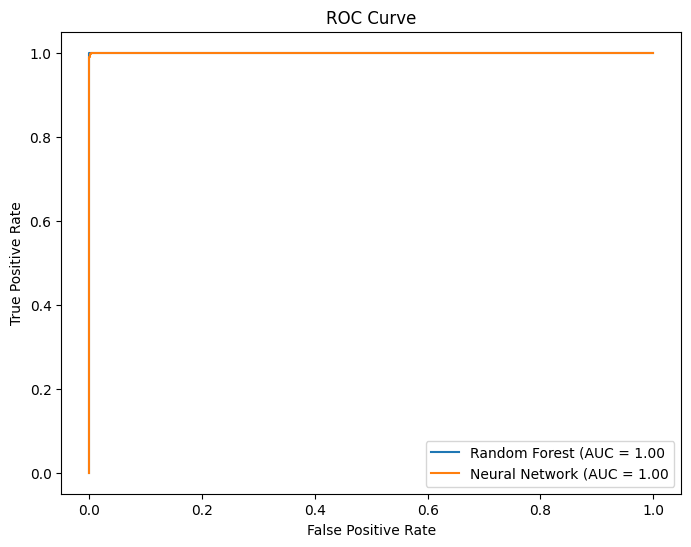

In [12]:
# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp.predict_proba(X_test)[:,1])

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc(fpr_rf, tpr_rf):.2f}')
plt.plot(fpr_mlp, tpr_mlp, label=f'Neural Network (AUC = {auc(fpr_mlp, tpr_mlp):.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()